# Deep Learning
Week Eight - Sept 19, 2022

Note, the author has all of the code available on [Github](https://github.com/joelgrus/data-science-from-scratch)

A few DNN fun sites:
* Create a random but non-existant generated person photo [here](https://thispersondoesnotexist.com/)
* Then create DNN-NLP [text to speech here](https://voicemaker.in/)
* And you that to create your own 'deep fake' marketing videos: [D-ID](https://studio.d-id.com/)

## Examples

### DALL-E AI Generated Art

![Perceptron vs NN vs DNN](./img/PerceptronToDNN.png)
Prompt: <code>"robot-owl posing next to an futuristic fighter jet, sci-fi digital rendering, studio lighting"</code>
![RoboOwl](./img/DALL%C2%B7E%202022-08-27%2010.42.24%20-%20robot-owl%20posing%20next%20to%20an%20futuristic%20fighter%20jet%2C%20sci-fi%20digital%20rendering%2C%20studio%20lighting%20.png)

Prompt: <code>"DALL·E 2022-08-27 11.11.55 - robot trying to solve a complex equation on a whiteboard in a classroom"</code>
![Machine Teaching](./img/DALL%C2%B7E%202022-08-27%2011.11.55%20-%20robot%20trying%20to%20solve%20a%20complex%20equation%20on%20a%20whiteboard%20in%20a%20classroom.png)

Prompt: <code>"DALL·E 2022-09-11 18.54.55 - A golden Labrador retriever playing chess"</code>
![Chess Dog](./img/DALL%C2%B7E%202022-09-11%2018.54.55%20-%20A%20golden%20Labrador%20retriever%20playing%20chess.png)

Prompt: <code>"A photo of a statue of a dragon reading a book"</code>
![Book Dragon](./img/DALL%C2%B7E%202022-09-11%2018.41.04%20-%20A%20photo%20of%20a%20statue%20of%20a%20dragon%20reading%20a%20book.png)

Source: 11yo daughter's [treatise on Mashed Potatoes](./img/potatoes.mp4). Photo from [thispersondoesnotexist.com](https://thispersondoesnotexist.com/) and video/Text-to-speech generated from [D-ID](https://studio.d-id.com/)

<video width="480" height="480" controls>
  <source src="https://github.com/bigfastdata/MLTrainingCourse/blob/2022Spring/WSG2022Spring/img/potatoes.mp4?raw=true" type="video/mp4">
</video>




## Chapter 19 - Deep Learning


In [2]:
import math, random, sys, os
# Setting up to use the author's library, cloned into the 'scratch' folder here (MIT License retained)
sys.path.insert(0,os.path.abspath('.'))

# Let us first install the scikit-learn packages
!conda install --yes --prefix {sys.prefix} python-mnist
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} tqdm
!conda install --yes --prefix {sys.prefix} mnist-python

/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found


In [1]:
Tensor = list

from typing import List

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensonal (that is, a vector).
    """
    return not isinstance(tensor[0], list)

assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4]])

def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

assert tensor_sum([1, 2, 3]) == 6
assert tensor_sum([[1, 2], [3, 4]]) == 10

from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4]]) == [[2, 4], [6, 8]]

def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1, 2, 3]) == [0, 0, 0]
assert zeros_like([[1, 2], [3, 4]]) == [[0, 0], [0, 0]]

def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]

import operator
assert tensor_combine(operator.add, [1, 2, 3], [4, 5, 6]) == [5, 7, 9]
assert tensor_combine(operator.mul, [1, 2, 3], [4, 5, 6]) == [4, 10, 18]

from typing import Iterable, Tuple

class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params()
        """
        return ()

from scratch.neural_networks import sigmoid

class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        """
        Apply sigmoid to each element of the input tensor,
        and save the results to use in backpropagation.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)

import random

from scratch.probability import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
assert shape(random_normal(5, 6, mean=10)) == [5, 6]

def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

from scratch.linear_algebra import dot

class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

from typing import List

class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

class SSE(Loss):
    """Loss function that computes the sum of the squared errors."""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Compute the tensor of squared differences
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual)

        # And just add them up
        return tensor_sum(squared_errors)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual)


sse_loss = SSE()
assert sse_loss.loss([1, 2, 3], [10, 20, 30]) == 9 ** 2 + 18 ** 2 + 27 ** 2
assert sse_loss.gradient([1, 2, 3], [10, 20, 30]) == [-18, -36, -54]

class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)

tensor = [[1, 2], [3, 4]]

for row in tensor:
    row = [0, 0]
assert tensor == [[1, 2], [3, 4]], "assignment doesn't update a list"

for row in tensor:
    row[:] = [0, 0]
assert tensor == [[0, 0], [0, 0]], "but slice assignment does"

class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

import math

def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1.
    # We check for this because e.g. math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use in backward pass.
        self.tanh = tensor_apply(tanh, input)
        return self.tanh

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient)

class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                              self.input,
                              gradient)

def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stabilitity.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight".
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]


class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)

class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the specified probability.
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Multiply by the mask to dropout inputs.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly.
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")


#plt.savefig('im/mnist.png')
#plt.gca().clear()

def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

assert one_hot_encode(3) == [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
assert one_hot_encode(2, num_labels=5) == [0, 0, 1, 0, 0]


from scratch.linear_algebra import squared_distance

import json

def save_weights(model: Layer, filename: str) -> None:
    weights = list(model.params())
    with open(filename, 'w') as f:
        json.dump(weights, f)

def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)

    # Check for consistency
    assert all(shape(param) == shape(weight)
               for param, weight in zip(model.params(), weights))

    # Then load using slice assignment:
    for param, weight in zip(model.params(), weights):
        param[:] = weight


    # XOR revisited
    
# training data
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]
    
random.seed(0)
    
net = Sequential([
        Linear(input_dim=2, output_dim=2),
        Sigmoid(),
        Linear(input_dim=2, output_dim=1)
    ])
    
from tqdm.notebook import tqdm
    
optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()
    
with tqdm(range(3000)) as t:
        for epoch in t:
            epoch_loss = 0.0
    
            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)
    
                optimizer.step(net)
    
            t.set_description(f"xor loss {epoch_loss:.3f}")
    
for param in net.params():
        print(param)
    
    




  0%|          | 0/3000 [00:00<?, ?it/s]

[[-1.6425160695224112, -1.494811779830316], [-4.567646572029666, -3.364917635073191]]
[1.7673716823255166, 0.3872701437947265]
[[3.1986204791704047, -3.5018030621426237]]
[-0.6462765963362195]


<Figure size 640x480 with 0 Axes>

In [ ]:
# FizzBuzz Revisited

print("FizzBuzz Revisited...")
from scratch.neural_networks import binary_encode, fizz_buzz_encode, argmax
    
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]
  
NUM_HIDDEN = 25
    
random.seed(0)
    
net = Sequential([
        Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
        Tanh(),
        Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
        Sigmoid()
    ])
    
def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
        num_correct = 0
        for n in range(low, hi):
            x = binary_encode(n)
            predicted = argmax(net.forward(x))
            actual = argmax(fizz_buzz_encode(n))
            if predicted == actual:
                num_correct += 1
    
        return num_correct / (hi - low)
    
optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SSE()
    
with tqdm(range(1000)) as t:
        for epoch in t:
            epoch_loss = 0.0
    
            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)
    
                optimizer.step(net)
    
            accuracy = fizzbuzz_accuracy(101, 1024, net)
            t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")
    
# Now check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))
    
random.seed(0)
    
net = Sequential([
        Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
        Tanh(),
        Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
        # No final sigmoid layer now
    ])
    
optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()
  
with tqdm(range(100)) as t:
        for epoch in t:
            epoch_loss = 0.0
    
            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)
    
                optimizer.step(net)
    
            accuracy = fizzbuzz_accuracy(101, 1024, net)
            t.set_description(f"fb loss: {epoch_loss:.3f} acc: {accuracy:.2f}")
    
# Again check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))
    
    

FizzBuzz Revisited...


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading MNIST training images (this might take a minute)...
Loading MNIST training labels...
Plotting first 100 sample images...


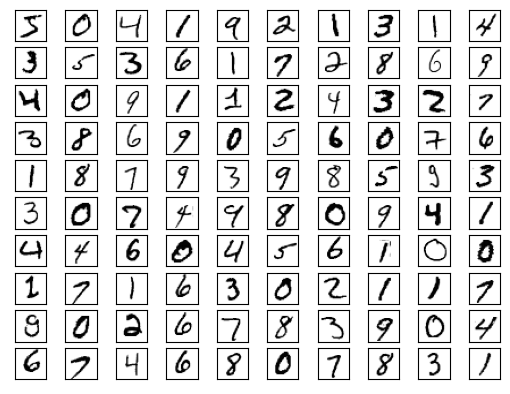

Training using SoftMaxCrossEntropy and momentum...


  0%|          | 0/25000 [00:00<?, ?it/s]

Training time = 126.9519 seconds
Test set...


  0%|          | 0/2500 [00:00<?, ?it/s]

Training using Dropout...


  0%|          | 0/25000 [00:00<?, ?it/s]

Training time = 395.8721 seconds
Test data set (from dropout trained model)


  0%|          | 0/2500 [00:00<?, ?it/s]

In [33]:
# Load the MNIST data
import mnist, os, time
    
# This will download the data, change this to where you want it.
# (Yes, it's a 0-argument function, that's what the library expects.)
# (Yes, I'm assigning a lambda to a variable, like I said never to do.)
tmpPath = "./tmp"
if not os.path.exists(tmpPath):
    os.mkdir(tmpPath, 755,  exist_ok=True) 
mnist.temporary_dir = lambda: tmpPath
    
NTest = 2500   # Up to 10000
NTrain = 25000 # Up to 60000
    
# Each of these functions first downloads the data and returns a numpy array.
# We call .tolist() because our "tensors" are just lists.
print("Loading MNIST training images (this might take a minute)...")
train_images =  mnist.train_images().tolist()[:NTrain]
print("Loading MNIST training labels...")
train_labels = mnist.train_labels().tolist()[:NTrain]
    
assert shape(train_images) == [NTrain, 28, 28]
assert shape(train_labels) == [NTrain]
    
import matplotlib.pyplot as plt
    
fig, ax = plt.subplots(10, 10)
   
print("Plotting first 100 sample images...")
for i in range(10):
        for j in range(10):
            # Plot each image in black and white and hide the axes.
            ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
            ax[i][j].xaxis.set_visible(False)
            ax[i][j].yaxis.set_visible(False)
    
plt.show()
    
    
# Load the MNIST test data
    
test_images = mnist.test_images().tolist()[:NTest]
test_labels = mnist.test_labels().tolist()[:NTest]
    
assert shape(test_images) == [NTest, 28, 28]
assert shape(test_labels) == [NTest]
    
    
# Recenter the images
    
# Compute the average pixel value
avg = tensor_sum(train_images) / NTrain / 28 / 28
    
# Recenter, rescale, and flatten
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                    for image in train_images]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                   for image in test_images]
    
assert shape(train_images) == [NTrain, 784], "images should be flattened"
assert shape(test_images) == [NTest, 784], "images should be flattened"
    
# After centering, average pixel should be very close to 0
assert -0.0001 < tensor_sum(train_images) < 0.0001
    
    
# One-hot encode the test data
    
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]
    
assert shape(train_labels) == [NTrain, 10]
assert shape(test_labels) == [NTest, 10]
    
    
# Training loop
    
   
def loop(model: Layer,
             images: List[Tensor],
             labels: List[Tensor],
             loss: Loss,
             optimizer: Optimizer = None) -> None:
        correct = 0         # Track number of correct predictions.
        total_loss = 0.0    # Track total loss.
    
        with tqdm(range(len(images))) as t:
            for i in t:
                predicted = model.forward(images[i])             # Predict.
                if argmax(predicted) == argmax(labels[i]):       # Check for
                    correct += 1                                 # correctness.
                total_loss += loss.loss(predicted, labels[i])    # Compute loss.
    
                # If we're training, backpropagate gradient and update weights.
                if optimizer is not None:
                    gradient = loss.gradient(predicted, labels[i])
                    model.backward(gradient)
                    optimizer.step(model)
    
                # And update our metrics in the progress bar.
                avg_loss = total_loss / (i + 1)
                acc = correct / (i + 1)
                t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.4f}")
    
    
# The logistic regression model for MNIST
    
random.seed(0)
    
# Logistic regression is just a linear layer followed by softmax
model = Linear(784, 10)
loss = SoftmaxCrossEntropy()
    
# This optimizer seems to work
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
    
# Train on the training data
print("Training using SoftMaxCrossEntropy and momentum...")
tic = time.perf_counter()
loop(model, train_images, train_labels, loss, optimizer)
print("Training time = %0.4f seconds" % (time.perf_counter() - tic))    
# Test on the test data (no optimizer means just evaluate)
print("Test set...")
loop(model, test_images, test_labels, loss)
    
    
# A deep neural network for MNIST
random.seed(0)
    
# Name them so we can turn train on and off
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)
    
model = Sequential([
        Linear(784, 30),  # Hidden layer 1: size 30
        dropout1,
        Tanh(),
        Linear(30, 10),   # Hidden layer 2: size 10
        dropout2,
        Tanh(),
        Linear(10, 10)    # Output layer: size 10
    ])
    
    
# Training the deep model for MNIST
    
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()
    
# Enable dropout and train (takes > 20 minutes on my laptop!)
dropout1.train = dropout2.train = True
print("Training using Dropout...")
tic = time.perf_counter()
loop(model, train_images, train_labels, loss, optimizer)
print("Training time = %0.4f seconds" % (time.perf_counter() - tic))  

# Disable dropout and evaluate
dropout1.train = dropout2.train = False
print("Test data set (from dropout trained model)")
loop(model, test_images, test_labels, loss)

### Using Scikit-Learn's NN

| Run                  | #Train | Train (sec) | Accuracy |
|:---:                 | :---:  | ---:        | :---     |
|Book1 (Base)          | 25000  | 126.952     | 87.9%    | 
|Book2 (Dropout)       | 25000  | 395.872     | 88.8%    |
|Scikit (SGD,Ident)    | 25000  |  24.147     | 82.8%    |
|Scikit (SGD,ReLU)     | 25000  |  20.226     | 80.8%    |
|Scikit (lbfgs,Ident)  | 25000  |1044.074     | 81.5%    |

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score as ACC
import numpy as np

dnn = MLPRegressor(solver='adam',       # solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
            activation='identity',          # activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
            learning_rate="constant",   # learning_rate{‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’
            learning_rate_init=0.01,
            alpha=1e-5,
            hidden_layer_sizes=(30,10,10),
            random_state=1,
            max_iter=500,
            shuffle=True,
            momentum=0.99,
            verbose=False
            )

print("Training using Scikit...")
tic = time.perf_counter()
dnn.fit( train_images, train_labels)
print("Training time = %0.4f seconds" % (time.perf_counter() - tic))  
print("Accuracy %0.4f:" % ACC(np.argmax(test_labels, axis=1),np.argmax(dnn.predict(test_images), axis=1)))


## Activation Functions
 * identity - straight linear y=x
 * step - sudden transition from 0 to 1 at the threshold
 * Rectified Linear Unit (ReLU) - significantly faster to compute, but behaves similar to sigmoidal
 * tanh - similar to sigmoidal, but -1 to +1
 * logistical/sigmoidal - similar to tanh, but 0-1

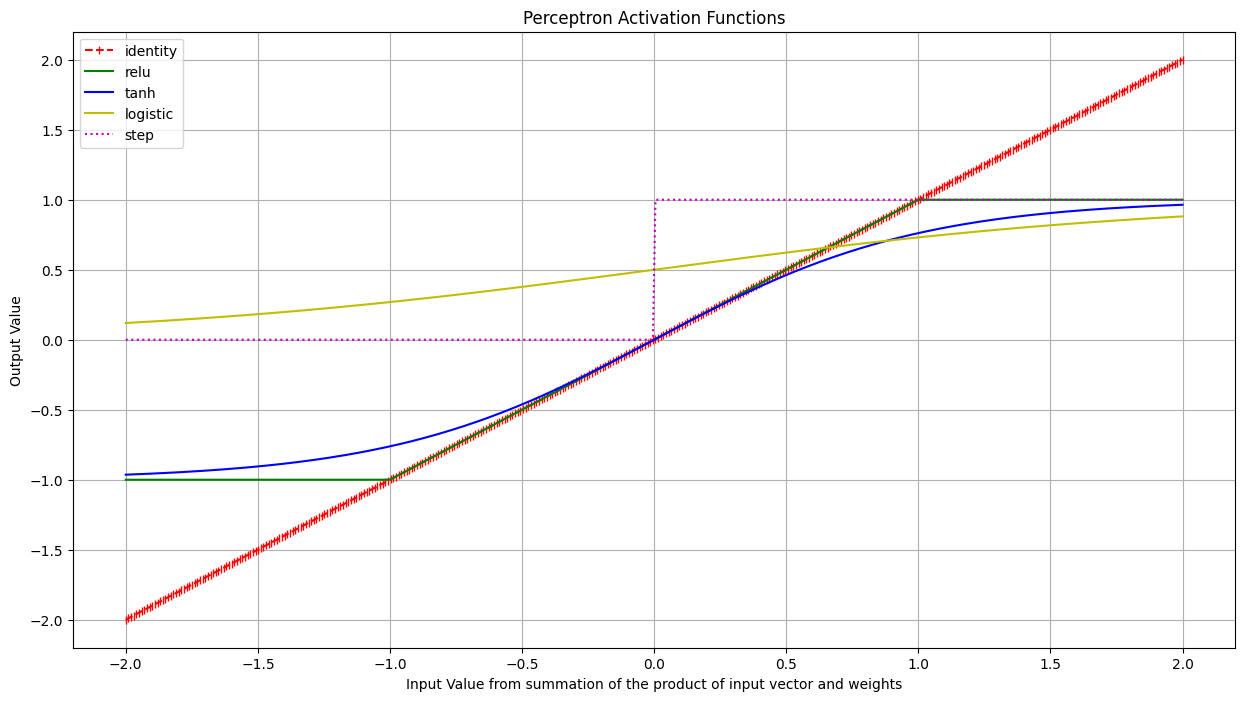

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

def step_funct(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

x = np.linspace(-2, 2, 400)
y1 = [ i for i in x]
y2 = [ max(-1,min(i,1)) for i in x]
y3 = np.tanh(
    x)  
y4 = [(1/(1+math.exp(-i))) for i in x] 
y5 = [step_funct(i) for i in x]

fig, ax = plt.subplots()
ax.plot(x, y1, 'r|--', label='identity')
ax.plot(x, y2, color='g', label='relu')
ax.plot(x, y3, color='b', label='tanh')
ax.plot(x, y4, color='y', label='logistic')
ax.plot(x, y5,'m:', label='step')
plt.gcf().set_size_inches(15,8)
plt.xlabel("Input Value from summation of the product of input vector and weights")
plt.ylabel("Output Value")
plt.title("Perceptron Activation Functions")
plt.grid(True, which='both')
plt.legend()
plt.show()
